In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from joblib import load as j_load
from joblib import dump as j_dump
import pickle
import tuning_parameters as tp
import numpy as np
import os

In [2]:
path2root = "../"
subjects_fol = "subjects/"
models_fol = "models/"
models_boi_fol = "boi/"
trained_fol = "trained/"
data_boi_fol = "data-boi/"
r_train = 0.85
n_epochs = 2
patience = 1
trainable_layers = 1
chosen_inputs = [0, 1, 2, 6, 7, 8, 9]

In [3]:
trained_dir = path2root + models_fol + models_boi_fol + trained_fol
public_model_dir = trained_dir + f"model{tp.MODEL_BLINK_OUT_IN_NUM}"
public_scalers_dir = trained_dir + f"scalers{tp.MODEL_BLINK_OUT_IN_NUM}.bin"
sbj_dir = path2root + subjects_fol + f"{tp.NUMBER}/"

In [4]:
print("\nLoading subject data in in_blink_out folder...")
data_boi_dir = sbj_dir + data_boi_fol
with open(data_boi_dir + "x1.pickle", "rb") as f:
    x1_load = pickle.load(f)
with open(data_boi_dir + "x2.pickle", "rb") as f:
    x2_load = pickle.load(f)
with open(data_boi_dir + "y.pickle", "rb") as f:
    y_load = pickle.load(f)
n_smp, frame_h, frame_w = x1_load.shape[:-1]
print(f"Sapmles number: {n_smp}")


Loading subject data in in_blink_out folder...
Sapmles number: 60


In [5]:
import matplotlib.pyplot as plt

[ 2.90088087  0.06944803 -0.15008799  3.02945633 -3.65793277 56.22252096
  0.45436421  0.47427553  0.46212459  0.46236947]
2.0


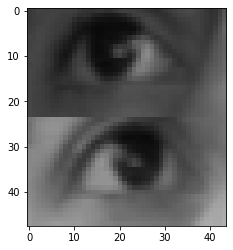

In [6]:
smp_num = 0
print(x2_load[smp_num])
print(y_load[smp_num])
plt.imshow(x1_load[smp_num].reshape((frame_h, frame_w)), cmap="gray", vmin=0, vmax=255)
plt.show()

In [7]:
print("\nNormalizing data...")
x2_chs_inp = x2_load[:, chosen_inputs]
scalers = j_load(public_scalers_dir)
x1_scaler, x2_scaler = scalers
x1 = x1_load / x1_scaler
x2 = x2_scaler.transform(x2_chs_inp)
scalers_dir = sbj_dir + "scalers-boi.bin"
j_dump(scalers, scalers_dir)


Normalizing data...


['../subjects/7/scalers-boi.bin']

In [8]:
print("\nShuffling data...")
x1_shf, x2_shf, y_shf = shuffle(x1, x2, y_load)


Shuffling data...


In [9]:
print("\nSplitting data to train and test...")
n_train = int(r_train * n_smp)
n_test = n_smp - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_test, x2_test = x1_shf[n_train:], x2_shf[n_train:]
y_train = y_shf[:n_train]
y_test = y_shf[n_train:]
print("Data shapes:")
print(x1_train.shape, x1_test.shape, x2_train.shape, x2_test.shape,
      y_train.shape, y_test.shape)


Splitting data to train and test...
Data shapes:
(51, 48, 44, 1) (9, 48, 44, 1) (51, 7) (9, 7) (51,) (9,)


In [10]:
y_train_ctg = to_categorical(y_train)
y_test_ctg = to_categorical(y_test)

x_train = [x1_train, x2_train]
x_test = [x1_test, x2_test]

In [11]:
print("\nLoading 'blink_out_in' model...")
cb = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)
model = load_model(public_model_dir)


Loading 'blink_out_in' model...


In [12]:
for layer in model.layers[:-trainable_layers]:
    layer.trainable = False
print("\nModel summary:")
print(model.summary())


Model summary:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 44, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 22, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 22, 32)   12832       max_pooling2d[0][0]              
______________________________________________________________________________

In [13]:
print("\nRetraining the model...")
results = model.fit(x_train,
                    y_train_ctg,
                    validation_data=(x_test, y_test_ctg),
                    epochs=n_epochs,
                    callbacks=cb)
print("End of retraining...")


Retraining the model...
Epoch 1/2
2/2 [==============================] - 1s 236ms/step - loss: 3.1723 - acc: 0.2941 - val_loss: 2.4191 - val_acc: 0.2222
Epoch 2/2
2/2 [==============================] - 0s 56ms/step - loss: 1.8350 - acc: 0.3137 - val_loss: 1.5906 - val_acc: 0.4444
End of retraining...


In [14]:
model.save(sbj_dir + "model-boi")

INFO:tensorflow:Assets written to: ../subjects/7/model-boi\assets


In [15]:
yhat_train = model.predict(x_train).argmax(1)
yhat_test = model.predict(x_test).argmax(1)

Test
0.0
1


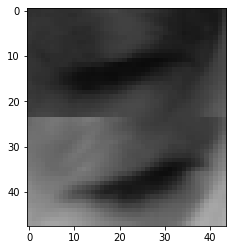

In [16]:
smp_num = 8
print("Test")
print(y_test[smp_num])
print(yhat_test[smp_num])
plt.imshow(
    (x1_test[smp_num].reshape((frame_h, frame_w)) * 255)
    .astype(np.uint8),
    cmap="gray",
    vmin=0,
    vmax=255
    )
plt.show()

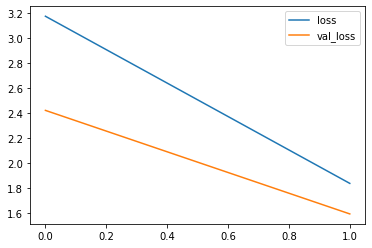

In [17]:
loss = results.history["loss"]
val_loss = results.history["val_loss"]
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()

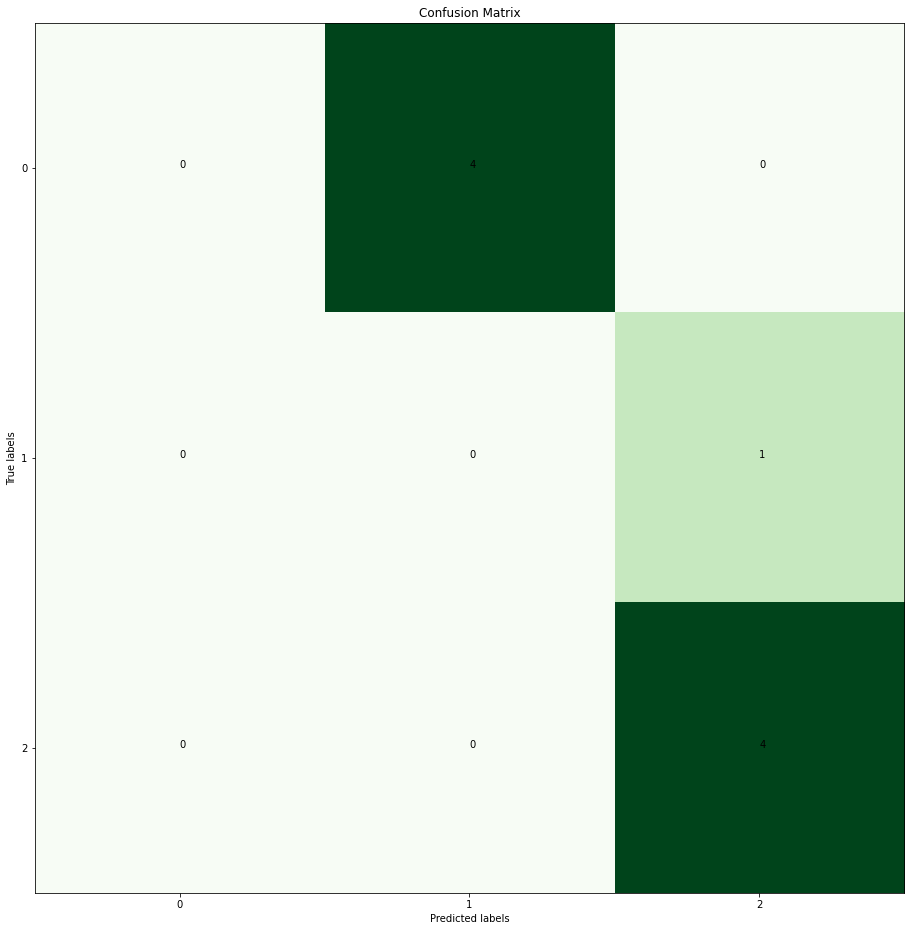

In [18]:
from sklearn.metrics import confusion_matrix

n_class = y_train_ctg.shape[1]
cm_test = confusion_matrix(y_test, yhat_test)
plt.figure(figsize=(16, 16))
plt.imshow(cm_test, cmap=plt.cm.Greens)
class_arr = np.arange(n_class)
plt.xticks(class_arr)
plt.yticks(class_arr)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

for i in range(n_class):
    for j in range(n_class):
        plt.text(i, j, cm_test[j][i])